## Before you start

### Configure your API keys

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [12]:
!nvidia-smi

Fri Mar  7 00:29:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   41C    P8             16W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install dependencjes

**Note:** Let's install the `inference-gpu` library, which will be used to efficiently run our object detection and keypoint detection models on GPUs. `inference-gpu` utilizes the `onnxruntime-gpu` library internally for optimal performance. We'll install a specific version of `onnxruntime-gpu` to guarantee compatibility with the CUDA 12 environment in Google Colab.

In [13]:
!pip install -q gdown inference-gpu
!pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

**Note:** Let's install the sports repository directly from GitHub. The sports repository contains a variety of football-related utilities that we'll use along the way.

In [14]:
!pip install -q git+https://github.com/roboflow/sports.git

  Preparing metadata (setup.py) ... done


**Note:** Let's make sure we have the latest features in the supervision library by installing version `0.23.0` or higher.

In [15]:
!pip uninstall -y supervision && pip install -q supervision>=0.23.0

Found existing installation: supervision 0.25.1
Uninstalling supervision-0.25.1:
  Successfully uninstalled supervision-0.25.1


**Note:** Let's download a few sample videos from the [DFL - Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout) Kaggle competition using gdown.



In [16]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /content/0bfacc_0.mp4
100% 19.9M/19.9M [00:00<00:00, 58.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: /content/2e57b9_0.mp4
100% 21.1M/21.1M [00:00<00:00, 75.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
To: /content/08fd33_0.mp4
100% 19.9M/19.9M [00:00<00:00, 70.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
To: /content/573e61_0.mp4
100% 18.9M/18.9M [00:00<00:00, 80.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /content/121364_0.mp4
100% 17.2M/17.2M [00:00<00:00, 70.3MB/s]


In [17]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

## ball, player, goalkeeper and referee detection

In [18]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
PLAYER_DETECTION_MODEL_ID = "basketball-players-fy4c2/16"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

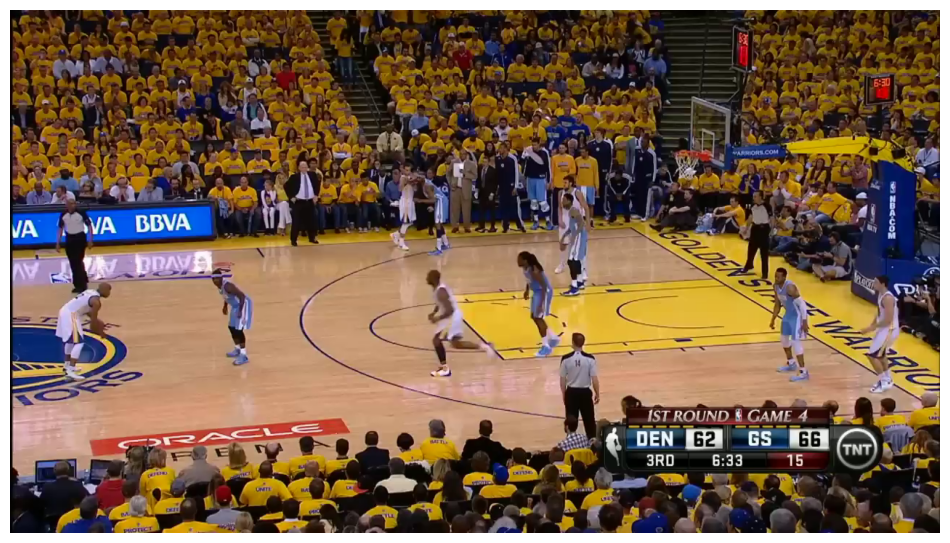

In [19]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/Train_GSW.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

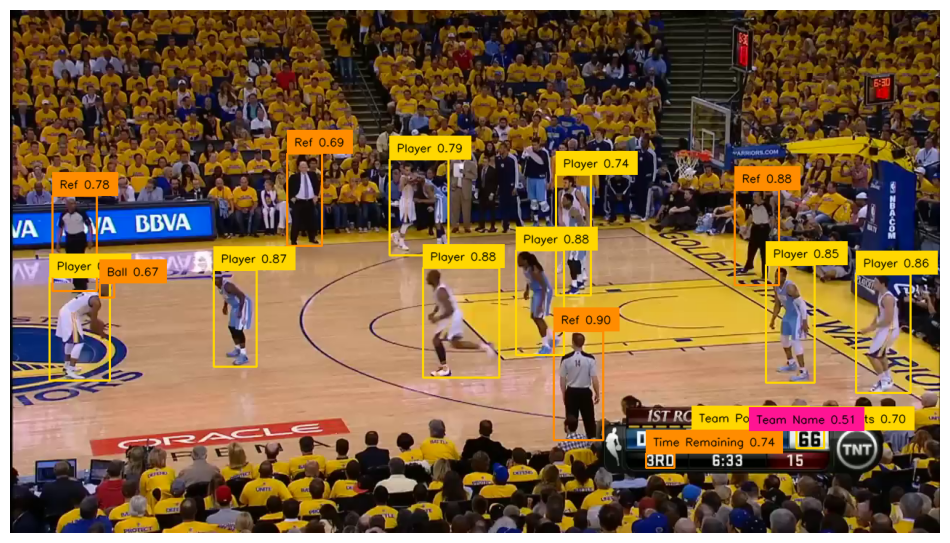

In [20]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/Train_GSW.mp4"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0] # j'ai du augmenter la confidence car certains objets étaient mal détectés commme des joueurs
detections = sv.Detections.from_inference(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

## video game style visualization

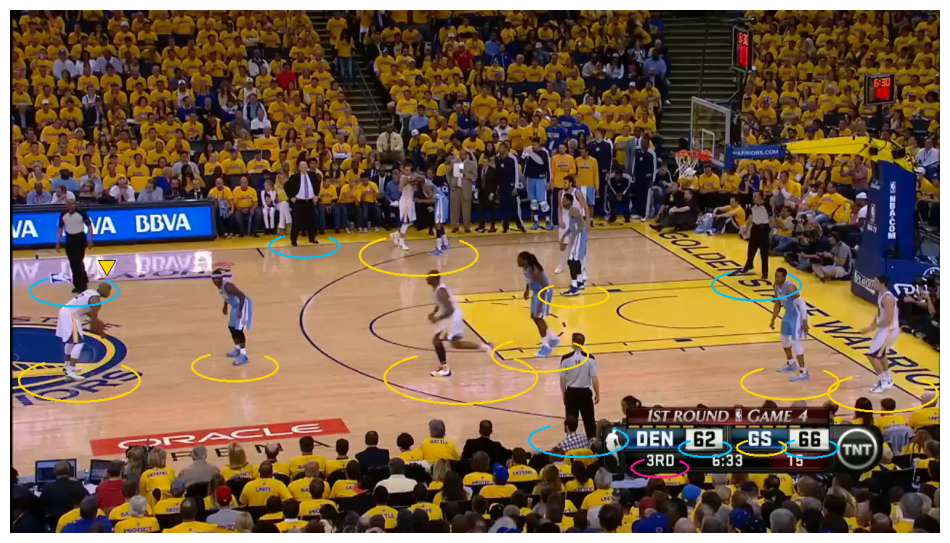

In [21]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/Train_GSW.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

## player tracking

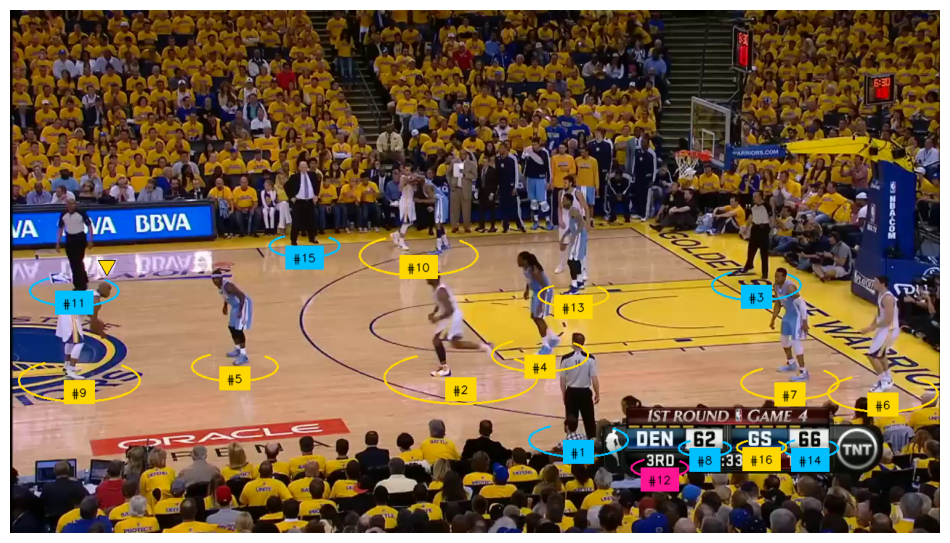

In [22]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/Train_GSW.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

## split players into teams

![football AI diagram](https://media.roboflow.com/notebooks/examples/football-ai-team-clustering.png)

**Note:** Before training our player clustering model, we need to gather training data. To do this, we'll sample one frame per second, detect players within those frames, and then crop them out.

collecting crops: 131it [00:11, 11.15it/s]


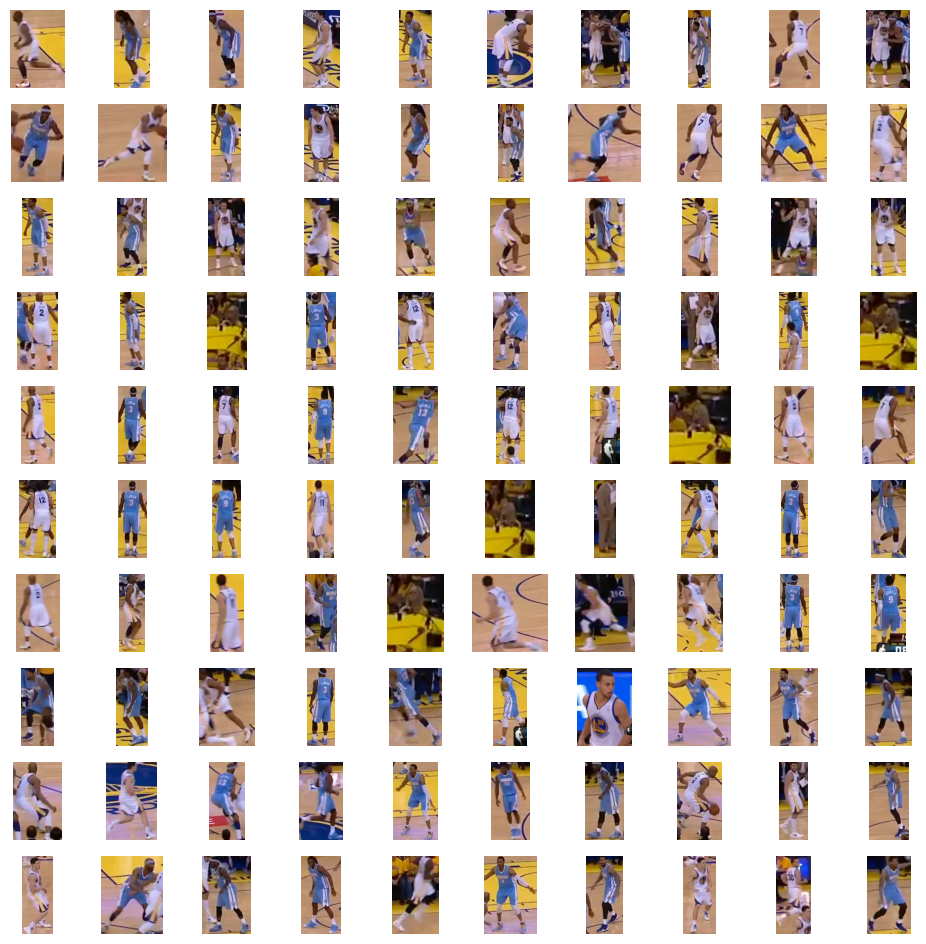

In [59]:
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/content/Train_GSW.mp4"
PLAYER_ID = 3
STRIDE = 35

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

In [60]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 20it [00:04,  4.30it/s]


In [74]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [75]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "/content/Train_GSW.mp4"
PLAYER_ID = 3
STRIDE = 35

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 131it [00:12, 10.30it/s]
Embedding extraction: 43it [00:09,  4.32it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Embedding extraction: 1it [00:00, 15.50it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



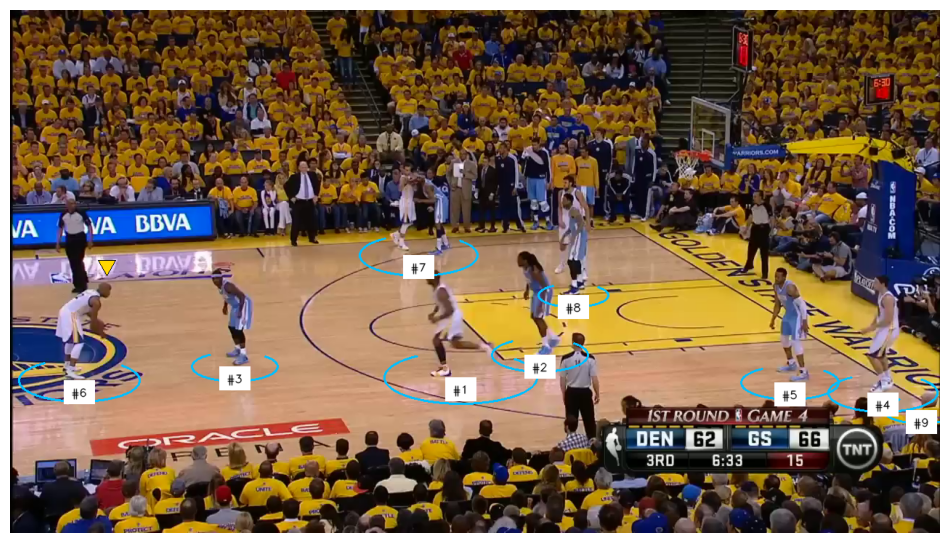

In [77]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/Train_GSW.mp4"
BALL_ID = 0
PLAYER_ID = 3
REFEREE_ID = 1

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493']),  # Couleurs équipes seulement
    thickness=2
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0]
detections = sv.Detections.from_inference(result)

# Détection ballon (si applicable)
ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

# Traitement joueurs
players_detections = detections[detections.class_id == PLAYER_ID]
players_detections = players_detections.with_nms(threshold=0.5, class_agnostic=True)
players_detections = tracker.update_with_detections(detections=players_detections)

# Classification équipes
players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

all_detections = sv.Detections.merge([
    players_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

## pitch keypoint detection

In [35]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

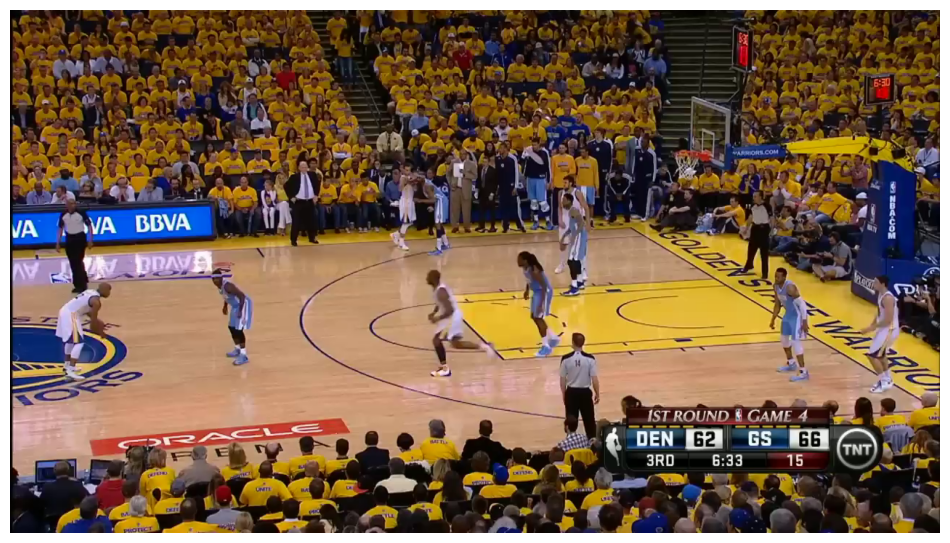

In [36]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/Train_GSW.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

**Note:** Notice that some of the keypoints we detected are in incorrect locations. These are keypoints with a low confidence level. Let's filter out these keypoints and keep only the ones the model is confident about.

## filter low confidence keypoints

In [37]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/Train_GSW.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

TypeError: 'NoneType' object is not subscriptable

## project pitch lines on frame

**Note:** The [sports](https://github.com/roboflow/sports) repository contains a [`SoccerPitchConfiguration`](https://github.com/roboflow/sports/blob/06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1/sports/configs/soccer.py#L6) that provides information about the real-world geometry of the soccer pitch. It also includes utilities for visualizing elements located on the pitch.

In [ ]:
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

**Note:** It's time to utilize the keypoint pairs located on the camera perspective plane and the football pitch plane. The [sports](https://github.com/roboflow/sports) repository includes a [`ViewTransformer`](https://github.com/roboflow/sports/blob/06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1/sports/common/view.py#L7), which employs homography for perspective transformation.

In [38]:
import numpy as np
import supervision as sv
from sports.common.view import ViewTransformer

SOURCE_VIDEO_PATH = "/content/Train_GSW.mp4"

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

NameError: name 'CONFIG' is not defined

## project ball, players and referies on pitch

In [ ]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
PLAYER_ID = 3
STRIDE = 35

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [00:03,  6.89it/s]
Embedding extraction: 18it [00:04,  4.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
import cv2
from typing import Optional

def draw_pitch_voronoi_diagram_2(
    config: SoccerPitchConfiguration,
    team_1_xy: np.ndarray,
    team_2_xy: np.ndarray,
    team_1_color: sv.Color = sv.Color.RED,
    team_2_color: sv.Color = sv.Color.WHITE,
    opacity: float = 0.5,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws a Voronoi diagram on a soccer pitch representing the control areas of two
    teams with smooth color transitions.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        team_1_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 1.
        team_2_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 2.
        team_1_color (sv.Color, optional): Color representing the control area of
            team 1. Defaults to sv.Color.RED.
        team_2_color (sv.Color, optional): Color representing the control area of
            team 2. Defaults to sv.Color.WHITE.
        opacity (float, optional): Opacity of the Voronoi diagram overlay.
            Defaults to 0.5.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw the
            Voronoi diagram on. If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with the Voronoi diagram overlay.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((
        scaled_width + 2 * padding,
        scaled_length + 2 * padding
    ))

    y_coordinates -= padding
    x_coordinates -= padding

    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                       (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    # Increase steepness of the blend effect
    steepness = 15  # Increased steepness for sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    # Create the smooth color transition
    for c in range(3):  # Iterate over the B, G, R channels
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] +
                            (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

Embedding extraction: 1it [00:00,  7.72it/s]


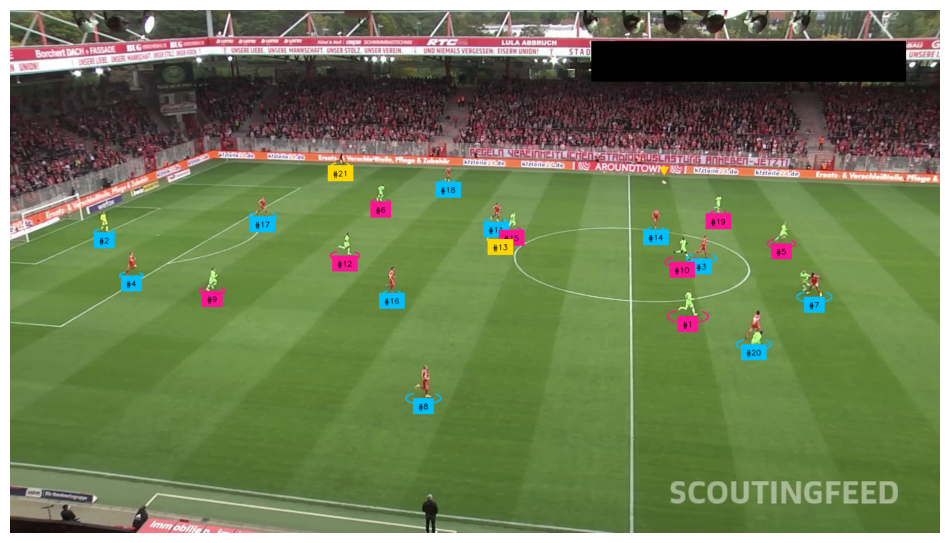

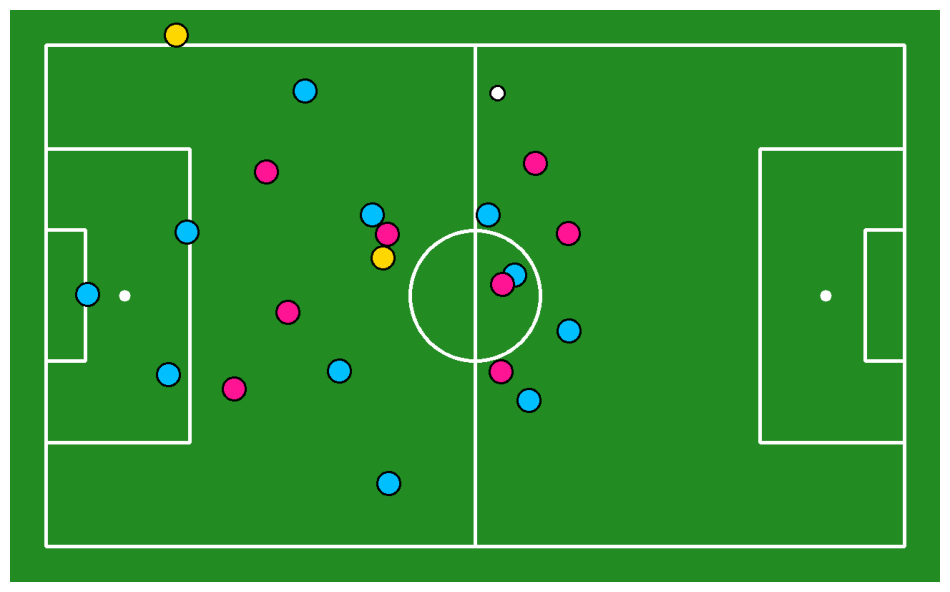

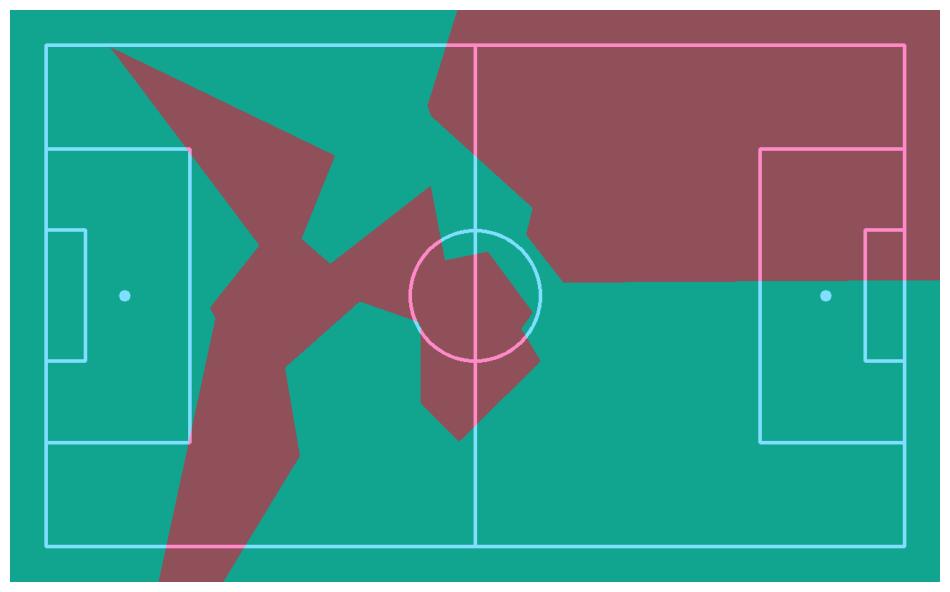

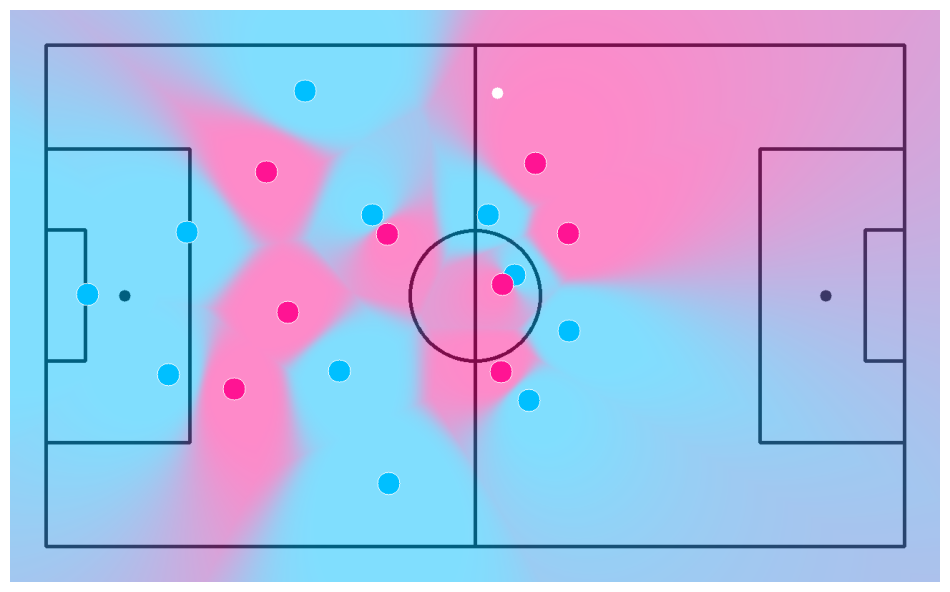

In [ ]:
import supervision as sv
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# ball, goalkeeper, player, referee detection

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# team assignment

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

# frame visualization

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])

# detect pitch key points

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# project ball, players and referies on pitch

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = transformer.transform_points(points=referees_xy)

# visualize video game-style radar view

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referees_xy,
    face_color=sv.Color.from_hex('FFD700'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_pitch_voronoi_diagram(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram with blend

annotated_frame = draw_pitch(
    config=CONFIG,
    background_color=sv.Color.WHITE,
    line_color=sv.Color.BLACK
)
annotated_frame = draw_pitch_voronoi_diagram_2(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.WHITE,
    radius=8,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

## ball tracking

In [ ]:
from collections import deque
import supervision as sv
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
BALL_ID = 0
MAXLEN = 5

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

path_raw = []
M = deque(maxlen=MAXLEN)

for frame in tqdm(frame_generator, total=video_info.total_frames):

    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )
    M.append(transformer.m)
    transformer.m = np.mean(np.array(M), axis=0)

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    path_raw.append(pitch_ball_xy)

100%|██████████| 750/750 [01:34<00:00,  7.95it/s]


In [ ]:
path = [
    np.empty((0, 2), dtype=np.float32) if coorinates.shape[0] >= 2 else coorinates
    for coorinates
    in path_raw
]

path = [coorinates.flatten() for coorinates in path]

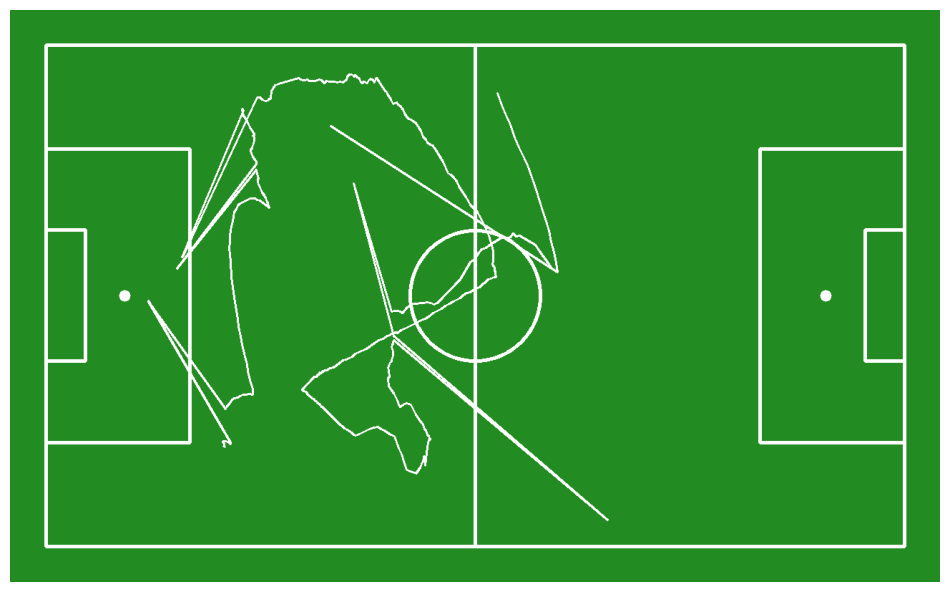

In [ ]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

In [ ]:
from typing import List, Union

def replace_outliers_based_on_distance(
    positions: List[np.ndarray],
    distance_threshold: float
) -> List[np.ndarray]:
    last_valid_position: Union[np.ndarray, None] = None
    cleaned_positions: List[np.ndarray] = []

    for position in positions:
        if len(position) == 0:
            # If the current position is already empty, just add it to the cleaned positions
            cleaned_positions.append(position)
        else:
            if last_valid_position is None:
                # If there's no valid last position, accept the first valid one
                cleaned_positions.append(position)
                last_valid_position = position
            else:
                # Calculate the distance from the last valid position
                distance = np.linalg.norm(position - last_valid_position)
                if distance > distance_threshold:
                    # Replace with empty array if the distance exceeds the threshold
                    cleaned_positions.append(np.array([], dtype=np.float64))
                else:
                    cleaned_positions.append(position)
                    last_valid_position = position

    return cleaned_positions

In [ ]:
MAX_DISTANCE_THRESHOLD = 500

path = replace_outliers_based_on_distance(path, MAX_DISTANCE_THRESHOLD)

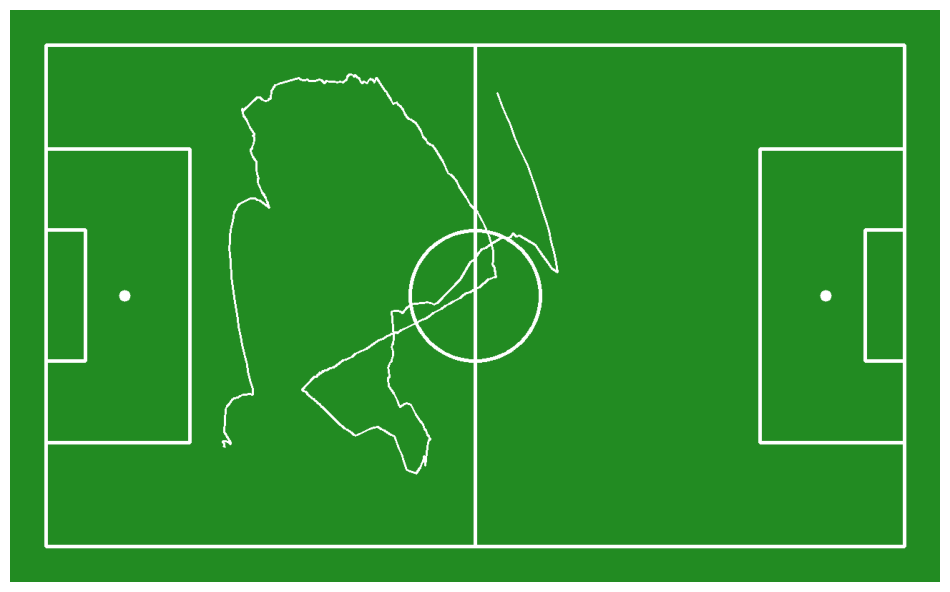

In [ ]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)